# Predict stock prices  with Long short-term memory (LSTM)

This simple example will show you how LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet. 

## Install requirements
We install Tensorflow 2.0 with GPU support first

In [1]:
!pip install -qU pip
!pip install -q tensorflow pandas-datareader

In [2]:
!pip install -q pydot pydot-ng

In [3]:
!pip install -Uq yfinance pandas-datareader

In [4]:
import os

scratch_path = os.environ.get("SCRATCH", "./scratch")
if not os.path.exists(scratch_path):
    os.makedirs(scratch_path)

## Introduction

LSTMs are very powerful in sequence prediction problems. They can store past information.

## Loading the dataset
I use pandas-datareader to get the historical stock prices from Yahoo! finance. For this example, I get only the historical data till the end of *training_end_data*.  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
import numpy as np  # python library for scientific computing
import pandas as pd  # python library for data manipulation and analysis
import matplotlib.pyplot as plt  # python library for charting
from pandas_datareader import (
    data as pdr,
)  # extract data from internet sources into pandas data frame
import yfinance as yf
import tensorflow as tf

2023-09-14 02:51:16.455910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 02:51:17.339575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-14 02:51:17.339672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-14 02:51:17.339684: W 

In [7]:
tickers = "IBM"

start_date = "1980-12-01"
end_date = "2018-12-31"

yf.pdr_override()
stock_data = pdr.get_data_yahoo(tickers, start_date)

[*********************100%%**********************]  1 of 1 completed


In [8]:
stock_data_len = stock_data["Close"].count()
print(f"Read in {stock_data_len} stock values")

Read in 10787 stock values


In [9]:
close_prices = stock_data.iloc[:, 1:2].values
# print(close_prices)

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices

In [10]:
all_bussinessdays = pd.date_range(start=start_date, end=end_date, freq="B")
print(all_bussinessdays)

DatetimeIndex(['1980-12-01', '1980-12-02', '1980-12-03', '1980-12-04',
               '1980-12-05', '1980-12-08', '1980-12-09', '1980-12-10',
               '1980-12-11', '1980-12-12',
               ...
               '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
               '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', length=9936, freq='B')


In [11]:
close_prices = stock_data.reindex(all_bussinessdays)
close_prices = stock_data.fillna(method="ffill")

The dataset is now complete and free of missing values. Let's have a look to the data frame summary:

## Feature scaling

In [12]:
training_set = close_prices.iloc[:, 1:2].values

In [13]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
# print(training_set_scaled.shape)

LSTMs expect the data in a specific format, usually a 3D tensor. I start by creating data with 60 days and converting it into an array using NumPy. Next, I convert the data into a 3D dimension array with feature_set samples, 60 days and one feature at each step.

In [14]:
features = []
labels = []
for i in range(60, stock_data_len):
    features.append(training_set_scaled[i - 60 : i, 0])
    labels.append(training_set_scaled[i, 0])

features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))

Feature tensor with three dimension: features[0] contains the ..., features[1] contains the last 60 days of values and features [2] contains the  ...

## Create the LSTM network
Let's create a sequenced LSTM network with 50 units. Also the net includes some dropout layers with 0.2 which means that 20% of the neurons will be dropped.

In [15]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.LSTM(
            units=50, return_sequences=True, input_shape=(features.shape[1], 1)
        ),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(units=50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(units=50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(units=50),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=1),
    ]
)

2023-09-14 02:51:19.230954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-14 02:51:19.230984: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-14 02:51:19.231021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (demo-0): /proc/driver/nvidia/version does not exist
2023-09-14 02:51:19.231384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

The model will be compiled and optimize by the adam optimizer and set the loss function as mean_squarred_error

In [17]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [18]:
from time import time

start = time()
history = model.fit(features, labels, epochs=5, batch_size=32, verbose=1)
end = time()

Epoch 1/5
336/336 [==============================] - 59s 160ms/step - loss: 0.0052
Epoch 2/5
336/336 [==============================] - 49s 146ms/step - loss: 0.0022
Epoch 3/5
336/336 [==============================] - 51s 153ms/step - loss: 0.0020
Epoch 4/5
336/336 [==============================] - 51s 152ms/step - loss: 0.0016
Epoch 5/5
336/336 [==============================] - 51s 152ms/step - loss: 0.0015


In [19]:
print("Total training time {} seconds".format(end - start))

Total training time 261.99090576171875 seconds


In [20]:
import os
# save tf model format
tf.keras.models.save_model(model, os.path.join(scratch_path, "stocks/1"))

INFO:tensorflow:Assets written to: ./scratch/stocks/1/assets


INFO:tensorflow:Assets written to: ./scratch/stocks/1/assets


In [21]:
import tf2onnx
import onnx
import os

# onnx model format
model_proto, _ = tf2onnx.convert.from_keras(model)
onnx.save(model_proto, os.path.join(scratch_path, "stocks.onnx"))

2023-09-14 02:55:55.772642: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-09-14 02:55:56.058616: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-09-14 02:55:56.268008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


In [22]:
testing_start_date = "2019-01-01"
testing_end_date = "2019-04-10"

test_stock_data = pdr.get_data_yahoo(tickers, testing_start_date, testing_end_date)

[*********************100%%**********************]  1 of 1 completed


In [23]:
test_stock_data_processed = test_stock_data.iloc[:, 1:2].values

In [24]:
all_stock_data = pd.concat((stock_data["Close"], test_stock_data["Close"]), axis=0)

In [25]:
inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 60 :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [26]:
X_test = []
for i in range(60, 129):
    X_test.append(inputs[i - 60 : i, 0])

In [27]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

3/3 [==============================] - 1s 23ms/step


In [35]:
print(X_test.dtype)
print(X_test.shape)
print(predicted_stock_price.dtype)
print(predicted_stock_price.shape)

float64
(69, 60, 1)
float32
(69, 1)


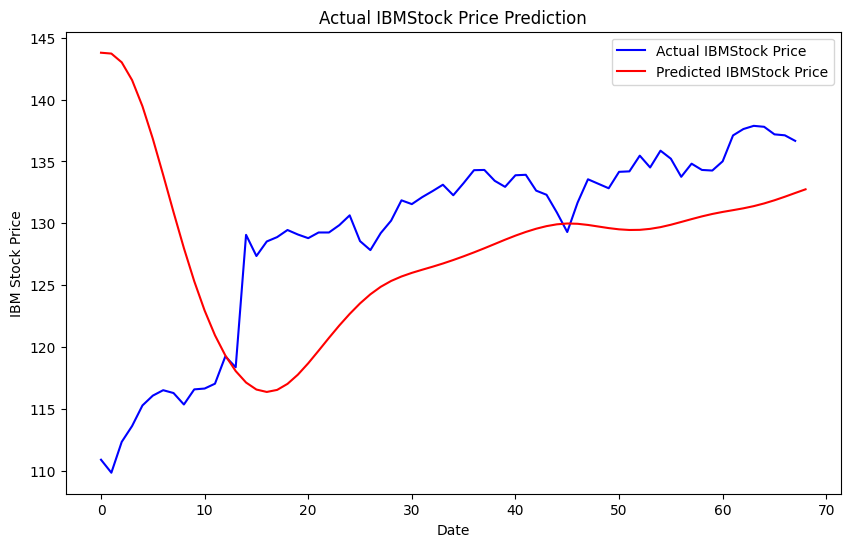

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_stock_data_processed, color="blue", label="Actual " + tickers + "Stock Price"
)
plt.plot(
    predicted_stock_price, color="red", label="Predicted " + tickers + "Stock Price"
)
plt.title("Actual " + tickers + "Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel(tickers + " Stock Price")
plt.legend()
plt.show()